In [63]:
#ensembling
from mlxtend.classifier import StackingCVClassifier
import numpy as np
import pandas as pd
import sys, os, glob
import imp
import seaborn as sns
sys.path.append('./src/')
import common_utils,my_ensembler, feature_utils, defines, model_utils, my_bert
from sklearn.neighbors import KNeighborsClassifier
from sklearn_crfsuite import scorers, CRF
from sklearn.pipeline import Pipeline
import json
from operator import itemgetter
from sklearn_crfsuite.utils import flatten
from sklearn_crfsuite.metrics import sequence_accuracy_score
from sklearn.linear_model import LogisticRegression
import scipy
import sklearn
import scipy.stats
from sklearn.metrics import make_scorer
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics
import classes
import pickle
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt


In [64]:
dir_name='reparse'
seq_len=15
step=15
cv_split_name='cv_splits_10'
merged_str='scaled.binary0.50_merged'
doc_indices=np.arange(1,81)
doc_indices
test_doc_num=8
seed=42

### Dataset without 76 document

In [ ]:
# imp.reload(classes)
# imp.reload(feature_utils)
# dataset=classes.Dataset(dir_name=dir_name,doc_indices=doc_indices,merged_str=merged_str)
# dataset.set_tf_params('lemma')
# dataset.set_tf_params('word')
# dataset.set_tf_params('char_wb')
# dataset.pack_dataset()
# dataset.pack_sent_per_paragraph()
# dataset.reshape(seq_len,step)
# dataset.dump_to_file("new.76")

### Load dataset

In [6]:
dataset=pickle.load( open( os.path.join(os.getcwd(),
                defines.PATH_TO_DFS,
                dir_name,
                "dataset_new.76"+
                ".p"),
                 "rb"))

In [ ]:
vars(dataset.tf_params['lemma'])

### Load splits of documents as were used for BERT

In [8]:
cv_splits_loaded=common_utils.load_json(dir_name,cv_split_name)
cv_splits_loaded

Opened /scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/reparse/cv_splits_10.json


{'0': {'test': [4, 14, 15, 18, 29, 32, 36, 70],
  'train': [1,
   2,
   3,
   5,
   6,
   7,
   8,
   9,
   10,
   11,
   12,
   13,
   16,
   17,
   19,
   20,
   21,
   22,
   23,
   24,
   25,
   26,
   27,
   28,
   30,
   31,
   33,
   34,
   35,
   37,
   38,
   39,
   40,
   41,
   42,
   43,
   44,
   45,
   46,
   47,
   48,
   49,
   50,
   51,
   52,
   53,
   54,
   55,
   56,
   57,
   58,
   59,
   60,
   61,
   62,
   63,
   64,
   65,
   66,
   67,
   68,
   69,
   71,
   72,
   73,
   74,
   75,
   76,
   77,
   78,
   79,
   80]},
 '1': {'test': [5, 6, 13, 34, 37, 62, 73, 80],
  'train': [1,
   2,
   3,
   4,
   7,
   8,
   9,
   10,
   11,
   12,
   14,
   15,
   16,
   17,
   18,
   19,
   20,
   21,
   22,
   23,
   24,
   25,
   26,
   27,
   28,
   29,
   30,
   31,
   32,
   33,
   35,
   36,
   38,
   39,
   40,
   41,
   42,
   43,
   44,
   45,
   46,
   47,
   48,
   49,
   50,
   51,
   52,
   53,
   54,
   55,
   56,
   57,
   58,
   59,
   60,
   61,
   6

### Run demo cross-validation on CRF using 2 splits of 2x document per each

In [ ]:
tmp_split={'0':{'test':[1],'train':[2]}, '1': {'test':[3],'train':[4]}, '2':{'test':[5],'train':[6]}}

In [ ]:
imp.reload(model_utils)
demo_crf_pred, demo_features =model_utils.prepared_cross_validate_crf(dataset, tmp_split, seq_len=seq_len, step=step)

In [ ]:
demo_crf_pred

In [ ]:
demo_features

In [ ]:
imp.reload(model_utils)
crf_scores, crf_dict, par_crf_scores, par_crf_dict = model_utils.get_report_from_splits(demo_crf_pred,"crf")

In [ ]:
np.mean(crf_scores),np.mean(par_crf_scores)

### Add retriving strong features from CRF

In [ ]:
imp.reload(model_utils)
my_crf = model_utils.CrfClassifier(crf_model=CRF(
                max_iterations=100,
                all_possible_transitions=True))

In [ ]:
my_crf.fit(dataset.get_x([1,2],'15_15'),dataset.get_y([1,2],'15_15'))

In [ ]:
my_crf.predict(dataset.get_y([3,4],'15_15'))

In [ ]:
my_crf.crf_model.state_features_
dataset.tf_params['lemma'].features

In [ ]:
dataset.tf_params

In [ ]:
imp.reload(model_utils)
ft = model_utils.get_estimator_features(my_crf.crf_model,**dataset.tf_params)
ft

In [ ]:
len(dataset.tf_params['lemma'].features)

In [ ]:
ft.query('attr.str.contains("lemma")')

In [ ]:
dataset.__class__.__name__

In [ ]:
dataset.doc_map[1].sent_list[0].text

### Run cross-validation on 80 files

In [6]:
imp.reload(common_utils)
crf_best_params=common_utils.load_pickle("","crf.rs.params.793")
crf_best_params

{'min_freq': 5, 'c2': 0.0071, 'c1': 0.459, 'algorithm': 'lbfgs'}

In [56]:
dataset=pickle.load( open( os.path.join(os.getcwd(),
                defines.PATH_TO_DFS,
                dir_name,
                "dataset_new.76"+
                ".p"),
                 "rb"))

In [17]:
dataset

In [ ]:
imp.reload(model_utils)
crf_res_db, crf_gtr_db =model_utils.prepared_cross_validate_crf(dataset, cv_splits_loaded, seq_len=seq_len, step=step, **crf_best_params)

In [10]:
crf_res_db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38781 entries, 0 to 38780
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   crf_group      38781 non-null  int64  
 1   crf_par        38781 non-null  int64  
 2   crf_split      38781 non-null  int64  
 3   crf_predicted  38781 non-null  object 
 4   crf_true       38781 non-null  object 
 5   crf_proba_0    38781 non-null  float64
 6   crf_proba_1    38781 non-null  float64
 7   crf_sent_idx   38781 non-null  int64  
dtypes: float64(2), int64(4), object(2)
memory usage: 2.4+ MB


In [11]:
crf_res_db

,crf_group,crf_par,crf_split,crf_predicted,crf_true,crf_proba_0,crf_proba_1,crf_sent_idx
0,4,0,0,not_nar,not_nar,0.928988,0.071012,0
1,4,1,0,not_nar,not_nar,0.948798,0.051202,1
2,4,2,0,not_nar,not_nar,0.963766,0.036234,2
3,4,3,0,not_nar,not_nar,0.891811,0.108189,3
4,4,3,0,not_nar,not_nar,0.769472,0.230528,4
...,...,...,...,...,...,...,...,...
38776,79,171,9,not_nar,not_nar,0.972802,0.027198,3773
38777,79,172,9,not_nar,not_nar,0.980269,0.019731,3774
38778,79,172,9,not_nar,not_nar,0.989618,0.010382,3775
38779,79,172,9,not_nar,not_nar,0.989894,0.010106,3776


In [ ]:
crf_res_db.groupby(['crf_group', 'crf_par']).apply(
        model_utils.par_contains_nar, kind='true', prefix='crf', nar_label='is_nar')

split 0
              precision    recall  f1-score   support

      is_nar       0.65      0.48      0.55       781
     not_nar       0.86      0.92      0.89      2597

    accuracy                           0.82      3378
   macro avg       0.75      0.70      0.72      3378
weighted avg       0.81      0.82      0.81      3378

MySegEval init called
MySegEval init called
split 1
              precision    recall  f1-score   support

      is_nar       0.62      0.38      0.47      1045
     not_nar       0.80      0.92      0.86      2911

    accuracy                           0.77      3956
   macro avg       0.71      0.65      0.66      3956
weighted avg       0.75      0.77      0.75      3956

MySegEval init called
MySegEval init called
split 2
              precision    recall  f1-score   support

      is_nar       0.60      0.49      0.54       915
     not_nar       0.83      0.88      0.85      2498

    accuracy                           0.78      3413
   macro avg    

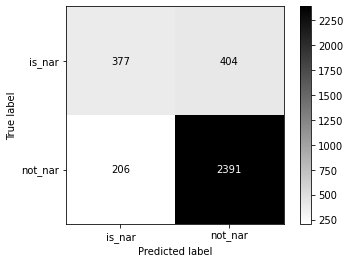

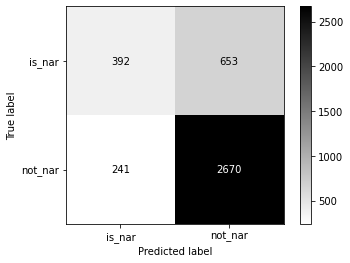

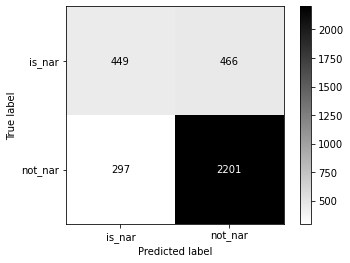

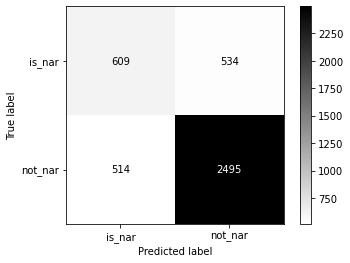

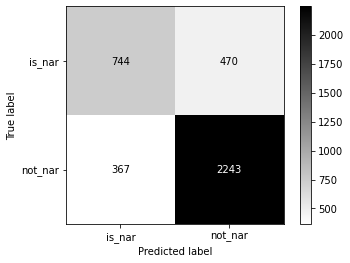

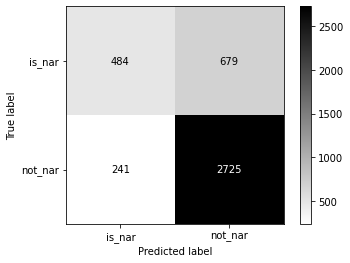

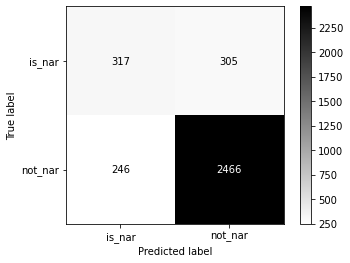

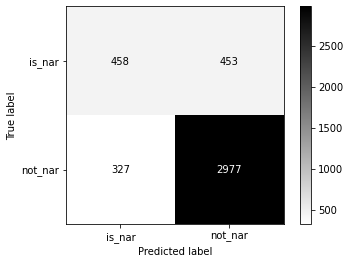

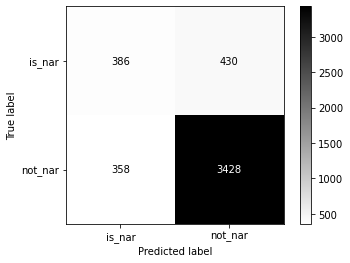

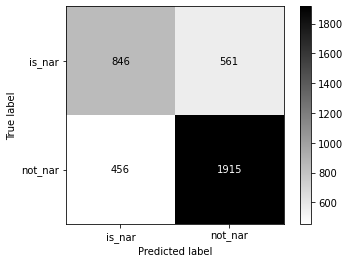

In [12]:
imp.reload(model_utils)
imp.reload(common_utils)
crf_scores, crf_dict, crf_par_scores, crf_par_dict = model_utils.get_report_by_unit(crf_res_db,"crf","split")

In [ ]:
imp.reload(model_utils)
crf_scores_doc, crf_dict_doc, crf_par_scores_doc, crf_par_dict_doc = model_utils.get_report_by_unit(crf_res_db,"crf",'group')

In [ ]:
for k,v in crf_dict_doc.items():
    print(k,v['segeval'])

In [ ]:
np.mean(crf_scores_doc),np.mean(crf_par_scores_doc)

In [ ]:
crf_dict['0'].keys()

In [13]:
common_utils.save_db(crf_res_db,dir_name,"crf.pred.new.76")

Saving /scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/reparse/crf.pred.new.76.csv,  index False


In [14]:
common_utils.save_db(crf_gtr_db,dir_name,"crf.features.new.76")

Saving /scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/reparse/crf.features.new.76.csv,  index False


In [19]:
del dataset
del crf_res_db
del crf_gtr_db

NameError: name 'crf_res_db' is not defined

## Cross-validate BERT

## Create demo dataset

In [ ]:
imp.reload(classes)
imp.reload(feature_utils)

demo_dataset=classes.Dataset(dir_name=dir_name,doc_indices=np.arange(1,81),merged_str=merged_str)
demo_dataset.set_tf_params('lemma')
demo_dataset.set_tf_params('word')
demo_dataset.set_tf_params('char_wb')
demo_dataset.pack_dataset()
demo_dataset.pack_sent_per_paragraph()
demo_dataset.reshape(seq_len,step)

In [ ]:
demo_dataset.doc_map[1].get_y()

In [ ]:
tmp_split

In [ ]:
imp.reload(common_utils)
imp.reload(my_bert)
imp.reload(model_utils)
bert_pred=my_bert.prepared_cross_validate_bert(docs_map=demo_dataset,
                                                cv_splits=cv_splits_loaded,
                                                epoch=3,
                                                batch_size=512,
                                                dir_name=dir_name,
                                                file_prefix='new.76')

In [ ]:
bert_pred=common_utils.load_db(dir_name,"bert_cv_db_all_new.76")

In [ ]:
imp.reload(model_utils)
bert_scores, bert_dict, bert_par_scores, bert_par_dict = model_utils.get_report_by_unit(bert_pred,"bert","split")

In [ ]:
np.mean(bert_par_scores),np.mean(bert_scores)

In [ ]:
bert_scores_doc, bert_dict_doc, bert_par_scores_doc, bert_par_dict_doc = model_utils.get_report_by_unit(bert_pred,"bert","group")

In [ ]:
np.mean(bert_par_scores_doc),np.mean(bert_scores_doc)

In [ ]:
del dataset

Remove 76 from splits

In [ ]:
crf_scores, crf_dict = model_utils.get_report_from_splits(cv_db_crf,"crf")

In [ ]:
crf_dict


In [ ]:
crf_scores,np.mean(crf_scores)

In [ ]:
worst_split=np.argmin(crf_scores)
worst_split

In [ ]:
f1={}
f1['is_nar']=[]
f1['not_nar']=[]
for label in f1.keys():
    for key,val in crf_dict.items():
        f1[label].append(val[label]['f1-score'])

In [ ]:
for k,v in f1.items():
    print(k,np.mean(v))

In [ ]:
colors=['r','b']
linestyle=['dashed','solid']

In [ ]:
from matplotlib import pyplot as plt
for y, c, st in zip(f1.keys(), colors,linestyle):
    data=f1[y]
    min_x = np.argmin(data)
    min_y = np.min(data)
    plt.plot(data,marker='o',color=c,linestyle=st,label=y)#, color='magenta', marker='o',mfc='pink' ) #plot the data
#     plt.scatter(min_x, min_y,c='r', label='minimum',zorder =1)
plt.xticks(range(0,len(data), 1)) #set the tick frequency on x-axis
plt.legend()
plt.ylabel('f-1 score') #set the label for y axis
plt.xlabel('fold index') #set the label for x-axis
plt.title('f-1 score per label') #set the title of the graph
plt.show() #display the graph

In [ ]:
f1

### Try single example

### Search parameters on prepared dataset with prepared splits (same as for BERT)

In [ ]:
dataset  = classes.Dataset(dir_name=dir_name,doc_indices=doc_indices,merged_str=merged_str)
dataset_loaded=pickle.load( open( os.path.join(dataset.path,"dataset_full.p"), "rb" ) )

In [ ]:
imp.reload(model_utils)
imp.reload(classes)

X,y,g,_ =  model_utils.get_X_y_by_doc_indices(dataset, doc_indices, seq_len, step)

In [ ]:
X[0]

In [ ]:
doc_indices

In [ ]:
cv_splits_loaded['0'].keys()

In [13]:
type(cv_splits_loaded)

dict

In [14]:
imp.reload(classes)
cv_split_classes = []
for key,val in cv_splits_loaded.items():
    cv_split_classes.append(classes.Split(val['train'],val['test']))
cv_split_classes

Split init called
Split init called
Split init called
Split init called
Split init called
Split init called
Split init called
Split init called
Split init called
Split init called


In [15]:
imp.reload(model_utils)
gsf = model_utils.GroupSplitFold(n_splits=len(cv_split_classes),prepared_splits=cv_split_classes)

for tr,ts in gsf.split():
    print(ts)

[4, 14, 15, 18, 29, 32, 36, 70]
[5, 6, 13, 34, 37, 62, 73, 80]
[7, 20, 39, 47, 48, 54, 57, 58]
[1, 19, 24, 27, 44, 56, 71, 75]
[12, 21, 26, 33, 41, 50, 76, 77]
[8, 11, 16, 40, 51, 53, 63, 72]
[9, 25, 30, 38, 49, 55, 59, 74]
[3, 10, 28, 31, 42, 45, 66, 68]
[2, 23, 43, 46, 61, 65, 67, 69]
[17, 22, 35, 52, 60, 64, 78, 79]


In [17]:
common_utils.dump_to_file(gsf,'auto.split')

In [ ]:
imp.reload(model_utils)
my_crf = model_utils.CrfClassifier(crf_model=CRF(
                max_iterations=100,
                all_possible_transitions=True))

In [ ]:
my_crf.find_best_params(X=X,y=y,groups=g,cv=gsf,random_state=seed)

### Merge BERT + CRF results

In [3]:
bert_pred=common_utils.load_db(dir_name,"bert_cv_db_all_new.76")
crf_pred=common_utils.load_db(dir_name,"crf.pred.new.76")
bert_pred.info(),crf_pred.info()

Opened /scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/reparse/bert_cv_db_all_new.76.csv,  index False
Opened /scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/reparse/crf.pred.new.76.csv,  index False
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38781 entries, 0 to 38780
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   bert_group      38781 non-null  int64  
 1   bert_split      38781 non-null  int64  
 2   bert_predicted  38781 non-null  int64  
 3   bert_true       38781 non-null  int64  
 4   bert_proba_0    38781 non-null  float64
 5   bert_proba_1    38781 non-null  float64
 6   bert_sent_idx   38781 non-null  int64  
 7   bert_par        38781 non-null  int64  
dtypes: float64(2), int64(6)
memory usage: 2.4 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38781 entries, 0 to 38780
Data columns (total 8 columns):
 #   Column         Non-

(None, None)

In [10]:
del bert_pred
del crf_pred

In [4]:
cv_splits_loaded=common_utils.load_json(dir_name,cv_split_name)
cv_splits_loaded

Opened /scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/reparse/cv_splits_10.json


{'0': {'test': [4, 14, 15, 18, 29, 32, 36, 70],
  'train': [1,
   2,
   3,
   5,
   6,
   7,
   8,
   9,
   10,
   11,
   12,
   13,
   16,
   17,
   19,
   20,
   21,
   22,
   23,
   24,
   25,
   26,
   27,
   28,
   30,
   31,
   33,
   34,
   35,
   37,
   38,
   39,
   40,
   41,
   42,
   43,
   44,
   45,
   46,
   47,
   48,
   49,
   50,
   51,
   52,
   53,
   54,
   55,
   56,
   57,
   58,
   59,
   60,
   61,
   62,
   63,
   64,
   65,
   66,
   67,
   68,
   69,
   71,
   72,
   73,
   74,
   75,
   76,
   77,
   78,
   79,
   80]},
 '1': {'test': [5, 6, 13, 34, 37, 62, 73, 80],
  'train': [1,
   2,
   3,
   4,
   7,
   8,
   9,
   10,
   11,
   12,
   14,
   15,
   16,
   17,
   18,
   19,
   20,
   21,
   22,
   23,
   24,
   25,
   26,
   27,
   28,
   29,
   30,
   31,
   32,
   33,
   35,
   36,
   38,
   39,
   40,
   41,
   42,
   43,
   44,
   45,
   46,
   47,
   48,
   49,
   50,
   51,
   52,
   53,
   54,
   55,
   56,
   57,
   58,
   59,
   60,
   61,
   6

In [6]:
bert_name="bert_cv_db_all_new.76"
crf_name="crf.pred.new.76"

In [7]:
imp.reload(model_utils)
merged_pred=model_utils.merge_pred_db(dir_name,bert_name,crf_name)

Opened /scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/reparse/bert_cv_db_all_new.76.csv,  index False
Opened /scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/reparse/crf.pred.new.76.csv,  index False


In [8]:
merged_pred

,bert_group,bert_split,bert_predicted,bert_true,bert_proba_0,bert_proba_1,bert_sent_idx,bert_par,crf_group,crf_par,crf_split,crf_predicted,crf_true,crf_proba_0,crf_proba_1,crf_sent_idx,ens_par
0,4,0,0,0,0.735761,0.264239,0,0,4,0,0,not_nar,not_nar,0.928988,0.071012,0,0
1,4,0,0,0,0.809237,0.190763,1,1,4,1,0,not_nar,not_nar,0.948798,0.051202,1,1
2,4,0,0,0,0.830174,0.169826,2,2,4,2,0,not_nar,not_nar,0.963766,0.036234,2,2
3,4,0,0,0,0.627892,0.372108,3,3,4,3,0,not_nar,not_nar,0.891811,0.108189,3,3
4,4,0,0,0,0.656868,0.343132,4,3,4,3,0,not_nar,not_nar,0.769472,0.230528,4,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38776,79,9,0,0,0.795311,0.204689,3773,171,79,171,9,not_nar,not_nar,0.972802,0.027198,3773,171
38777,79,9,0,0,0.860838,0.139162,3774,172,79,172,9,not_nar,not_nar,0.980269,0.019731,3774,172
38778,79,9,0,0,0.875573,0.124427,3775,172,79,172,9,not_nar,not_nar,0.989618,0.010382,3775,172
38779,79,9,0,0,0.865315,0.134685,3776,172,79,172,9,not_nar,not_nar,0.989894,0.010106,3776,172


In [9]:
common_utils.save_db(merged_pred,dir_name,"merged.crf.bert.pred.new.76")

Saving /scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/reparse/merged.crf.bert.pred.new.76.csv,  index False


In [ ]:
imp.reload(model_utils)
est=CRF(
                max_iterations=100,
                all_possible_transitions=True)
ens_pred=model_utils.prepared_cross_validate_ensemble(est,merged_pred,cv_splits_loaded,**{'seq_len':15,'seq_step':15})

In [ ]:
ens_scores, ens_dict, ens_par_scores, ens_par_dict = model_utils.get_report_by_unit(ens_pred,"ens","split")

In [ ]:
np.mean(ens_scores),np.mean(ens_par_scores)

In [ ]:
imp.reload(model_utils)
est=LogisticRegression()
ens_pred_linear=model_utils.prepared_cross_validate_ensemble(est,merged_pred,cv_splits_loaded)

In [ ]:
ens_scores_l, ens_dict_l, ens_par_scores_l, ens_par_dict_l = model_utils.get_report_by_unit(ens_pred_linear,"ens","split")

In [ ]:
np.mean(ens_scores_l),np.mean(ens_par_scores_l)

In [ ]:
ens_pred_linear

In [ ]:
common_utils.save_db(ens_pred_linear,dir_name,"lr.ens.pred.new.76")
common_utils.save_db(ens_pred,dir_name,"crf.ens.pred.new.76")

### Try different estimators for ensemble

In [ ]:
estimators_pred={}
imp.reload(feature_utils)
imp.reload(model_utils)

for regr in feature_utils.regressors_type:
    regr_name=regr.__class__.__name__
    print(regr_name)
    estimators_pred[regr_name]=model_utils.prepared_cross_validate_ensemble(regr,merged_pred,cv_splits_loaded)

In [ ]:
estimator_scores={}
for k,v in estimators_pred.items():
    sent_score, _, par_score, _ = model_utils.get_report_by_unit(v,"ens","split")
    estimator_scores[k]={}
    estimator_scores[k]['sent']=np.mean(sent_score)
    estimator_scores[k]['par']=np.mean(par_score)

In [ ]:
for k,v in estimator_scores.items():
    print ("{:>30} {}".format(k,v))


In [ ]:
common_utils.save_json(estimator_scores,dir_name,"ens.scores.new.76")

In [ ]:
for k,v in estimators_pred.items():
    common_utils.save_db(v,dir_name,"ens.{}.pred.new.76".format(k))

In [ ]:
for k,v in estimators_pred.items():
    del v
del estimators_pred

## Get dataframes to print in thesis book

### BERT

split 0
              precision    recall  f1-score   support

           0       0.86      0.86      0.86      2597
           1       0.53      0.52      0.52       781

    accuracy                           0.78      3378
   macro avg       0.69      0.69      0.69      3378
weighted avg       0.78      0.78      0.78      3378

MySegEval init called
MySegEval init called
split 1
              precision    recall  f1-score   support

           0       0.84      0.78      0.80      2911
           1       0.48      0.58      0.52      1045

    accuracy                           0.72      3956
   macro avg       0.66      0.68      0.66      3956
weighted avg       0.74      0.72      0.73      3956

MySegEval init called
MySegEval init called
split 2
              precision    recall  f1-score   support

           0       0.83      0.84      0.83      2498
           1       0.54      0.53      0.53       915

    accuracy                           0.75      3413
   macro avg    

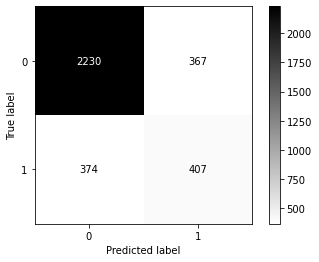

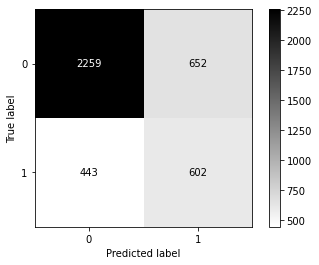

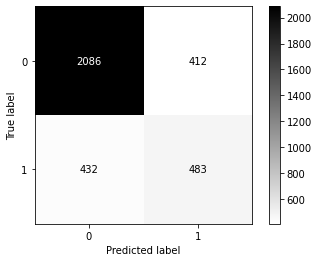

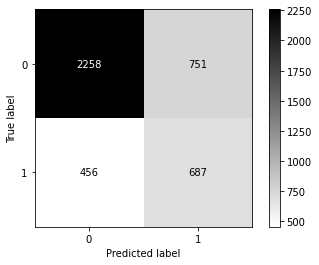

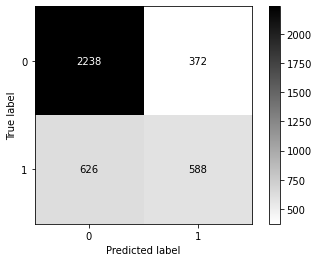

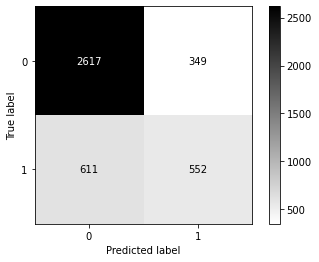

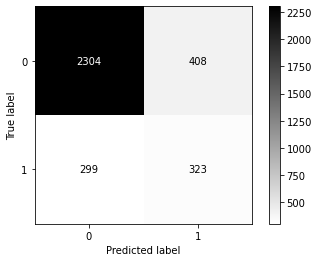

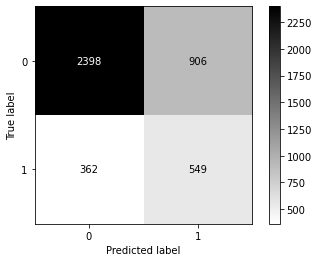

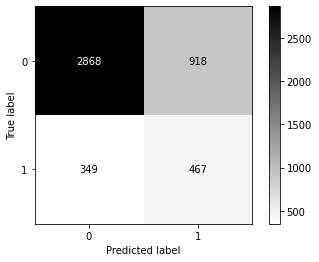

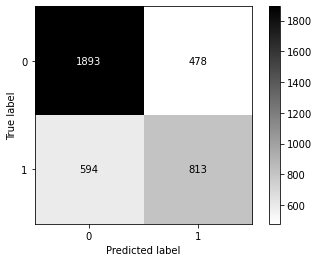

In [25]:
bert_pred
bert_scores, bert_dict, bert_par_scores, bert_par_dict = model_utils.get_report_by_unit(bert_pred,"bert","split")

In [95]:
imp.reload(classes)
labels=['1','0']
bert_rprt=classes.MyReport(bert_dict,bert_par_dict,'bert',labels)

MyReport init called


In [96]:
bert_print_df=bert_rprt.get_print_df()
bert_print_df


,sent_f1,par_f1,sent_recall,par_recall,sent_prec,par_prec
1,0.515761,0.467037,0.545716,0.612560,0.503458,0.387257
0,0.820226,0.814289,0.809126,0.755762,0.835163,0.886847
weighted avg,0.744586,0.747545,0.740042,0.726106,0.756066,0.792190


In [78]:
print_df.to_csv(sep='&',line_terminator="\\",float_format='%.3f')

'&sent_f1&par_f1&sent_recall&par_recall&sent_prec&par_prec\\1&0.516&0.467&0.546&0.613&0.503&0.387\\0&0.820&0.814&0.809&0.756&0.835&0.887\\weighted avg&0.745&0.748&0.740&0.726&0.756&0.792\\'

In [104]:
common_utils.dump_to_file(bert_rprt,"bert_report")

### CRF 

In [61]:
crf_pred=common_utils.load_db(dir_name,"crf.pred.new.76")


Opened /scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/reparse/crf.pred.new.76.csv,  index False


In [66]:
imp.reload(model_utils)
crf_scores, crf_dict, crf_par_scores, crf_par_dict = model_utils.get_report_by_unit(crf_pred,"crf","split",print_rep=False)

MySegEval init called
MySegEval init called
MySegEval init called
MySegEval init called
MySegEval init called
MySegEval init called
MySegEval init called
MySegEval init called
MySegEval init called
MySegEval init called
MySegEval init called
MySegEval init called
MySegEval init called
MySegEval init called
MySegEval init called
MySegEval init called
MySegEval init called
MySegEval init called
MySegEval init called
MySegEval init called


In [98]:
labels=['is_nar','not_nar']

crf_rprt=classes.MyReport(crf_dict,crf_par_dict,'crf',labels)

MyReport init called


In [99]:
crf_print_df=crf_rprt.get_print_df()
crf_print_df

,sent_f1,par_f1,sent_recall,par_recall,sent_prec,par_prec
is_nar,0.544544,0.493692,0.499708,0.459468,0.606244,0.541543
not_nar,0.859127,0.886444,0.884974,0.903634,0.835504,0.870513
weighted avg,0.781183,0.810291,0.788503,0.816288,0.779935,0.808117


In [81]:
print_df.to_csv(sep='&',line_terminator="\\",float_format='%.3f')

'&sent_f1&par_f1&sent_recall&par_recall&sent_prec&par_prec\\is_nar&0.545&0.494&0.500&0.459&0.606&0.542\\not_nar&0.859&0.886&0.885&0.904&0.836&0.871\\weighted avg&0.781&0.810&0.789&0.816&0.780&0.808\\'

In [103]:
common_utils.dump_to_file(crf_rprt,"crf_report")

### SVM report

In [3]:
svm_pred=common_utils.load_db(dir_name,"ens.SVC.pred.new.76")

Opened /scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/reparse/ens.SVC.pred.new.76.csv,  index False


In [5]:
svm_pred

,ens_predicted,ens_group,ens_split,ens_true,ens_par
0,0,4,0,0,0
1,0,4,0,0,1
2,0,4,0,0,2
3,0,4,0,0,3
4,0,4,0,0,3
...,...,...,...,...,...
38776,0,79,9,0,171
38777,0,79,9,0,172
38778,0,79,9,0,172
38779,0,79,9,0,172


In [4]:
svm_scores, svm_dict, svm_par_scores, svm_par_dict = model_utils.get_report_by_unit(svm_pred,"ens","split",print_rep=False)

MySegEval init called
MySegEval init called
MySegEval init called
MySegEval init called
MySegEval init called
MySegEval init called
MySegEval init called
MySegEval init called
MySegEval init called
MySegEval init called
MySegEval init called
MySegEval init called
MySegEval init called
MySegEval init called
MySegEval init called
MySegEval init called
MySegEval init called
MySegEval init called
MySegEval init called
MySegEval init called


In [88]:
svm_dict

{0: {'0': {'precision': 0.8499313186813187,
   'recall': 0.9530227185213708,
   'f1-score': 0.8985296787075693,
   'support': 2597},
  '1': {'precision': 0.7381974248927039,
   'recall': 0.44046094750320103,
   'f1-score': 0.5517241379310345,
   'support': 781},
  'accuracy': 0.8345174659561871,
  'macro avg': {'precision': 0.7940643717870113,
   'recall': 0.6967418330122859,
   'f1-score': 0.7251269083193019,
   'support': 3378},
  'weighted avg': {'precision': 0.8240982307449931,
   'recall': 0.8345174659561871,
   'f1-score': 0.818347580618027,
   'support': 3378},
  'segeval': {'f1': Decimal('0.2219178082191780821917808219'),
   'recall': Decimal('0.1248073959938366718027734977'),
   'precision': Decimal('0.1248073959938366718027734977'),
   'b_sim': Decimal('0.1219879518072289156626506024'),
   's_sim': Decimal('0.9136807817589576547231270358')}},
 1: {'0': {'precision': 0.8096221959858324,
   'recall': 0.9422878735829612,
   'f1-score': 0.8709318939514209,
   'support': 2911},
  

In [100]:
svm_rprt=classes.MyReport(svm_dict,svm_par_dict,'svm',labels=['1','0'])

MyReport init called


In [101]:
svm_print_df=svm_rprt.get_print_df()
svm_print_df

,sent_f1,par_f1,sent_recall,par_recall,sent_prec,par_prec
1,0.549619,0.518216,0.469672,0.458067,0.677116,0.606784
0,0.873889,0.898939,0.921331,0.927538,0.832262,0.872946
weighted avg,0.792773,0.824917,0.805330,0.833950,0.797360,0.824349


In [94]:
print_df.to_csv(sep='&',line_terminator="\\",float_format='%.3f')

'&sent_f1&par_f1&sent_recall&par_recall&sent_prec&par_prec\\1&0.550&0.518&0.470&0.458&0.677&0.607\\0&0.874&0.899&0.921&0.928&0.832&0.873\\weighted avg&0.793&0.825&0.805&0.834&0.797&0.824\\'

In [105]:
common_utils.dump_to_file(svm_rprt,"svm_report")

### Search parameters for ensembler

In [12]:
merged_pred

,bert_group,bert_split,bert_predicted,bert_true,bert_proba_0,bert_proba_1,bert_sent_idx,bert_par,crf_group,crf_par,crf_split,crf_predicted,crf_true,crf_proba_0,crf_proba_1,crf_sent_idx,ens_par
0,4,0,0,0,0.735761,0.264239,0,0,4,0,0,not_nar,not_nar,0.928988,0.071012,0,0
1,4,0,0,0,0.809237,0.190763,1,1,4,1,0,not_nar,not_nar,0.948798,0.051202,1,1
2,4,0,0,0,0.830174,0.169826,2,2,4,2,0,not_nar,not_nar,0.963766,0.036234,2,2
3,4,0,0,0,0.627892,0.372108,3,3,4,3,0,not_nar,not_nar,0.891811,0.108189,3,3
4,4,0,0,0,0.656868,0.343132,4,3,4,3,0,not_nar,not_nar,0.769472,0.230528,4,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38776,79,9,0,0,0.795311,0.204689,3773,171,79,171,9,not_nar,not_nar,0.972802,0.027198,3773,171
38777,79,9,0,0,0.860838,0.139162,3774,172,79,172,9,not_nar,not_nar,0.980269,0.019731,3774,172
38778,79,9,0,0,0.875573,0.124427,3775,172,79,172,9,not_nar,not_nar,0.989618,0.010382,3775,172
38779,79,9,0,0,0.865315,0.134685,3776,172,79,172,9,not_nar,not_nar,0.989894,0.010106,3776,172


### Set predicted by ensemble y to dataset

In [14]:
doc_idx=1
y_pred = common_utils.convert_binary_label_to_str(svm_pred.query('ens_group == @doc_idx')['ens_predicted'].tolist())

In [16]:
dataset.doc_map[1].set_pred_y(y_pred)

In [59]:
doc_df=pd.DataFrame()
doc_df.loc[doc_idx,'true']=model_utils.get_colored_from_list(dataset.doc_map[doc_idx].get_y(),'is_nar')
doc_df.loc[doc_idx,'pred']=model_utils.get_colored_from_list(dataset.doc_map[doc_idx].get_pred_y(),'is_nar')
doc_df

,true,pred
1,000|001|002|003|004|005|006|007|008|009|010|01...,000|001|002|003|004|005|006|007|008|009|010|01...


In [64]:
all_doc_colored=pd.DataFrame()
for doc_idx,doc in dataset.doc_map.items():
#     if doc_idx == 3:
#         break
    y_pred = common_utils.convert_binary_label_to_str(svm_pred.query('ens_group == @doc_idx')['ens_predicted'].tolist())
    doc.set_pred_y(y_pred)
    doc.colored_ind_df = pd.DataFrame()
    doc.colored_ind_df.loc[doc_idx,'true']=model_utils.get_colored_from_list(dataset.doc_map[doc_idx].get_y(),'is_nar')
    doc.colored_ind_df.loc[doc_idx,'pred']=model_utils.get_colored_from_list(dataset.doc_map[doc_idx].get_pred_y(),'is_nar')
    all_doc_colored.loc[doc_idx,'true']=doc.colored_ind_df.loc[doc_idx,'true']
    all_doc_colored.loc[doc_idx,'pred']=doc.colored_ind_df.loc[doc_idx,'pred']

In [74]:
dataset.dump_to_file("dataset_new.76.colored")

In [65]:
all_doc_colored

,true,pred
1,000|001|002|003|004|005|006|007|008|009|010|01...,000|001|002|003|004|005|006|007|008|009|010|01...
2,000|001|002|003|004|005|006|007|008|009|010|01...,000|001|002|003|004|005|006|007|008|009|010|01...
3,000|001|002|003|004|005|006|007|008|009|010|01...,<span class='corrStyle'>000|</span><span class...
4,000|001|002|003|004|<span class='corrStyle'>00...,000|001|002|003|004|<span class='corrStyle'>00...
5,000|001|002|003|004|005|006|007|008|009|010|<s...,000|001|002|003|004|005|006|007|008|009|010|<s...
...,...,...
76,000|001|002|003|004|005|006|007|008|009|010|01...,000|001|002|003|004|005|006|007|008|009|010|01...
77,000|001|002|003|004|005|006|007|008|009|010|01...,000|001|002|003|004|005|006|007|008|009|010|01...
78,000|001|002|003|<span class='corrStyle'>004|</...,000|001|002|003|<span class='corrStyle'>004|</...
79,000|001|002|<span class='corrStyle'>003|</span...,000|001|002|003|<span class='corrStyle'>004|</...


In [103]:
index=True
style="numeric_style"
html = all_doc_colored.to_html(
    escape=False, justify="center", index=index)
html = r'<link rel="stylesheet" type="text/css" href="{}.css" /><br>'.format(
    style) + html
# write html to file
print_df_path = os.path.join(
    dataset.path, "all_doc_colored.html"
)
# html
text_file = open(print_df_path, "w")
text_file.write(html)

text_file.close()

NameError: name 'all_doc_colored' is not defined

In [82]:
imp.reload(classes)
wd = classes.WindowDiff()

WindowDiff init called


In [124]:
y_tr=[1,0,1,0,1,1,0,0,0,1,1,1,0,1,1,0,0,0,1]
y_pr=[1,0,1,0,0,1,0,0,1,1,1,0,0,1,1,1,0,0,1]

In [137]:
for i,item in enumerate(y_tr):
    print('{:>4}{:>4}{:>4}'.format(i,item,y_pr[i]))

   0   1   1
   1   0   0
   2   1   1
   3   0   0
   4   1   0
   5   1   1
   6   0   0
   7   0   0
   8   0   1
   9   1   1
  10   1   1
  11   1   0
  12   0   0
  13   1   1
  14   1   1
  15   0   1
  16   0   0
  17   0   0
  18   1   1


In [126]:
y_true={}
start,end=wd.get_boundaries_indices(y_tr)
y_true['start']=start
y_true['end']=end
y_true

{'start': [0, 2, 4, 9, 13, 18], 'end': [1, 3, 6, 12, 15, 19]}

In [127]:
y_pred={}
start,end=wd.get_boundaries_indices(y_pr)
y_pred['start']=start
y_pred['end']=end
y_pred

{'start': [0, 2, 5, 8, 13, 18], 'end': [1, 3, 6, 11, 16, 19]}

In [128]:
import re
print(re.search('1$','0001'))

<re.Match object; span=(3, 4), match='1'>


In [129]:
misses=wd.get_near_miss_idx(y_true,y_pred)
misses

{'start': {'fp-1': [8], 'fn+1': [4]}, 'end': {'fn-1': [12], 'fp+1': [16]}}

In [138]:
start_true, end_true = wd.get_boundaries_indices(dataset.doc_map[1].get_y())

NameError: name 'dataset' is not defined

In [111]:
start_pred, end_pred = wd.get_boundaries_indices(dataset.doc_map[1].get_pred_y())

In [112]:
start_pred

[21,
 28,
 43,
 65,
 71,
 81,
 106,
 120,
 125,
 150,
 162,
 164,
 234,
 237,
 262,
 265,
 270,
 283,
 290,
 305,
 360,
 366,
 368,
 438,
 452,
 471,
 540]

In [110]:
start_true

[21, 91, 156, 219, 283, 306, 381, 394, 438, 453, 500, 527, 538]

In [104]:
dataset.doc_map[1].get_y()

['not_nar',
 'not_nar',
 'not_nar',
 'not_nar',
 'not_nar',
 'not_nar',
 'not_nar',
 'not_nar',
 'not_nar',
 'not_nar',
 'not_nar',
 'not_nar',
 'not_nar',
 'not_nar',
 'not_nar',
 'not_nar',
 'not_nar',
 'not_nar',
 'not_nar',
 'not_nar',
 'not_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'not_nar',
 'not_nar',
 'not_nar',
 'not_nar',
 'not_nar',
 'not_nar',
 'not_nar',
 'not_nar',
 'not_nar',
 'not_nar',
 'not_nar',
 'not_nar',
 'not_nar',
 'not_nar',
 'not_nar',
 'not_nar',
 'not_nar',
 'not_nar',
 'not_nar',
 'not_nar',
 'not_nar',
 'not_nar',
 'not_nar',

(-0.5, 1.5)

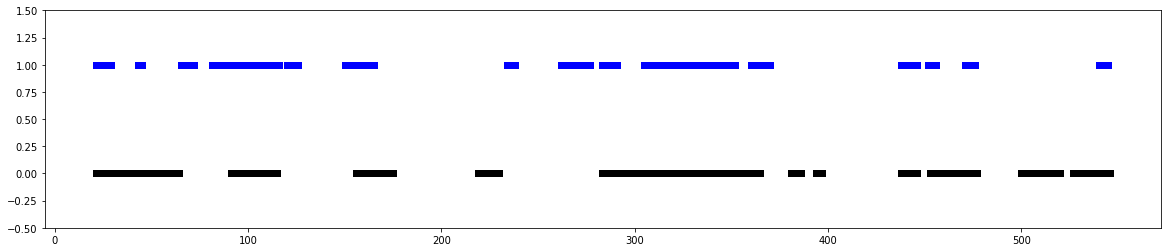

In [130]:
fig, ax = plt.subplots(figsize=(20, 4))



for idx,_ in enumerate(start_true):
    point1 = [start_true[idx],0]
    point2 = [end_true[idx],0]
    x_values = [point1[0], point2[0]]
    y_values = [point1[1], point2[1]]
    ax.plot(x_values, y_values, color='black', label='true', linewidth=7.0)
for idx,_ in enumerate(start_pred):
    point1 = [start_pred[idx],1]
    point2 = [end_pred[idx],1]
    x_values = [point1[0], point2[0]]
    y_values = [point1[1], point2[1]]
    ax.plot(x_values, y_values,color='blue', label='predicted',linewidth=7.0)
plt.ylim([-0.5,1.5])



### Concat ensemble SVC results with BERT and CRF

In [7]:
merged_db=common_utils.load_db(dir_name,"merged.crf.bert.pred.new.76")

Opened /scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/reparse/merged.crf.bert.pred.new.76.csv,  index False


In [8]:
svm_pred=common_utils.load_db(dir_name,"ens.SVC.pred.new.76")

Opened /scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/reparse/ens.SVC.pred.new.76.csv,  index False


In [10]:
merged_db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38781 entries, 0 to 38780
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   bert_group      38781 non-null  int64  
 1   bert_split      38781 non-null  int64  
 2   bert_predicted  38781 non-null  int64  
 3   bert_true       38781 non-null  int64  
 4   bert_proba_0    38781 non-null  float64
 5   bert_proba_1    38781 non-null  float64
 6   bert_sent_idx   38781 non-null  int64  
 7   bert_par        38781 non-null  int64  
 8   crf_group       38781 non-null  int64  
 9   crf_par         38781 non-null  int64  
 10  crf_split       38781 non-null  int64  
 11  crf_predicted   38781 non-null  object 
 12  crf_true        38781 non-null  object 
 13  crf_proba_0     38781 non-null  float64
 14  crf_proba_1     38781 non-null  float64
 15  crf_sent_idx    38781 non-null  int64  
 16  ens_par         38781 non-null  int64  
dtypes: float64(4), int64(11), objec

In [16]:
merged_db

,bert_group,bert_split,bert_predicted,bert_true,bert_proba_0,bert_proba_1,bert_sent_idx,bert_par,crf_group,crf_par,crf_split,crf_predicted,crf_true,crf_proba_0,crf_proba_1,crf_sent_idx,ens_par
0,4,0,0,0,0.735761,0.264239,0,0,4,0,0,not_nar,not_nar,0.928988,0.071012,0,0
1,4,0,0,0,0.809237,0.190763,1,1,4,1,0,not_nar,not_nar,0.948798,0.051202,1,1
2,4,0,0,0,0.830174,0.169826,2,2,4,2,0,not_nar,not_nar,0.963766,0.036234,2,2
3,4,0,0,0,0.627892,0.372108,3,3,4,3,0,not_nar,not_nar,0.891811,0.108189,3,3
4,4,0,0,0,0.656868,0.343132,4,3,4,3,0,not_nar,not_nar,0.769472,0.230528,4,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38776,79,9,0,0,0.795311,0.204689,3773,171,79,171,9,not_nar,not_nar,0.972802,0.027198,3773,171
38777,79,9,0,0,0.860838,0.139162,3774,172,79,172,9,not_nar,not_nar,0.980269,0.019731,3774,172
38778,79,9,0,0,0.875573,0.124427,3775,172,79,172,9,not_nar,not_nar,0.989618,0.010382,3775,172
38779,79,9,0,0,0.865315,0.134685,3776,172,79,172,9,not_nar,not_nar,0.989894,0.010106,3776,172


In [19]:
merged_db=merged_db.assign(bert_sent_idx=merged_db.groupby(['bert_group']).cumcount())

In [20]:
merged_db=merged_db.assign(crf_sent_idx=merged_db.groupby(['crf_group']).cumcount())

In [21]:
merged_db

,bert_group,bert_split,bert_predicted,bert_true,bert_proba_0,bert_proba_1,bert_sent_idx,bert_par,crf_group,crf_par,crf_split,crf_predicted,crf_true,crf_proba_0,crf_proba_1,crf_sent_idx,ens_par
0,4,0,0,0,0.735761,0.264239,0,0,4,0,0,not_nar,not_nar,0.928988,0.071012,0,0
1,4,0,0,0,0.809237,0.190763,1,1,4,1,0,not_nar,not_nar,0.948798,0.051202,1,1
2,4,0,0,0,0.830174,0.169826,2,2,4,2,0,not_nar,not_nar,0.963766,0.036234,2,2
3,4,0,0,0,0.627892,0.372108,3,3,4,3,0,not_nar,not_nar,0.891811,0.108189,3,3
4,4,0,0,0,0.656868,0.343132,4,3,4,3,0,not_nar,not_nar,0.769472,0.230528,4,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38776,79,9,0,0,0.795311,0.204689,254,171,79,171,9,not_nar,not_nar,0.972802,0.027198,254,171
38777,79,9,0,0,0.860838,0.139162,255,172,79,172,9,not_nar,not_nar,0.980269,0.019731,255,172
38778,79,9,0,0,0.875573,0.124427,256,172,79,172,9,not_nar,not_nar,0.989618,0.010382,256,172
38779,79,9,0,0,0.865315,0.134685,257,172,79,172,9,not_nar,not_nar,0.989894,0.010106,257,172


In [23]:
common_utils.save_db(merged_db,dir_name,"merged.crf.bert.pred.new.76.sent_idx")

Saving /scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/reparse/merged.crf.bert.pred.new.76.sent_idx.csv,  index False


In [11]:
svm_pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38781 entries, 0 to 38780
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   ens_predicted  38781 non-null  int64
 1   ens_group      38781 non-null  int64
 2   ens_split      38781 non-null  int64
 3   ens_true       38781 non-null  int64
 4   ens_par        38781 non-null  int64
dtypes: int64(5)
memory usage: 1.5 MB


In [15]:
svm_pred=svm_pred.assign(ens_sent_idx=svm_pred.groupby(['ens_group']).cumcount())
svm_pred

,ens_predicted,ens_group,ens_split,ens_true,ens_par,ens_sent_idx
0,0,4,0,0,0,0
1,0,4,0,0,1,1
2,0,4,0,0,2,2
3,0,4,0,0,3,3
4,0,4,0,0,3,4
...,...,...,...,...,...,...
38776,0,79,9,0,171,254
38777,0,79,9,0,172,255
38778,0,79,9,0,172,256
38779,0,79,9,0,172,257


In [24]:
common_utils.save_db(svm_pred,dir_name,"ens.SVC.pred.new.76.sent_idx")

Saving /scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/reparse/ens.SVC.pred.new.76.sent_idx.csv,  index False


In [22]:
all_pred =  merged_db.merge(svm_pred, left_on=['bert_group', 'bert_sent_idx'], right_on=[
        'ens_group', 'ens_sent_idx'], validate='one_to_one')

In [139]:
common_utils.save_db(all_pred,dir_name,"bert.crf.svc.new.76")

Saving /scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/reparse/bert.crf.svc.new.76.csv,  index False


In [26]:
del merged_db
del svm_pred

In [27]:
all_pred

,bert_group,bert_split,bert_predicted,bert_true,bert_proba_0,bert_proba_1,bert_sent_idx,bert_par,crf_group,crf_par,...,crf_proba_0,crf_proba_1,crf_sent_idx,ens_par_x,ens_predicted,ens_group,ens_split,ens_true,ens_par_y,ens_sent_idx
0,4,0,0,0,0.735761,0.264239,0,0,4,0,...,0.928988,0.071012,0,0,0,4,0,0,0,0
1,4,0,0,0,0.809237,0.190763,1,1,4,1,...,0.948798,0.051202,1,1,0,4,0,0,1,1
2,4,0,0,0,0.830174,0.169826,2,2,4,2,...,0.963766,0.036234,2,2,0,4,0,0,2,2
3,4,0,0,0,0.627892,0.372108,3,3,4,3,...,0.891811,0.108189,3,3,0,4,0,0,3,3
4,4,0,0,0,0.656868,0.343132,4,3,4,3,...,0.769472,0.230528,4,3,0,4,0,0,3,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38776,79,9,0,0,0.795311,0.204689,254,171,79,171,...,0.972802,0.027198,254,171,0,79,9,0,171,254
38777,79,9,0,0,0.860838,0.139162,255,172,79,172,...,0.980269,0.019731,255,172,0,79,9,0,172,255
38778,79,9,0,0,0.875573,0.124427,256,172,79,172,...,0.989618,0.010382,256,172,0,79,9,0,172,256
38779,79,9,0,0,0.865315,0.134685,257,172,79,172,...,0.989894,0.010106,257,172,0,79,9,0,172,257


### Calculate near-miss errors

In [132]:
all_pred.rename({'ens_par_x':'ens_par'},inplace=True,axis=1)

In [133]:
all_pred

,bert_group,bert_split,bert_predicted,bert_true,bert_proba_0,bert_proba_1,bert_sent_idx,bert_par,crf_group,crf_par,...,crf_proba_0,crf_proba_1,crf_sent_idx,ens_par,ens_predicted,ens_group,ens_split,ens_true,ens_par_y,ens_sent_idx
0,4,0,0,0,0.735761,0.264239,0,0,4,0,...,0.928988,0.071012,0,0,0,4,0,0,0,0
1,4,0,0,0,0.809237,0.190763,1,1,4,1,...,0.948798,0.051202,1,1,0,4,0,0,1,1
2,4,0,0,0,0.830174,0.169826,2,2,4,2,...,0.963766,0.036234,2,2,0,4,0,0,2,2
3,4,0,0,0,0.627892,0.372108,3,3,4,3,...,0.891811,0.108189,3,3,0,4,0,0,3,3
4,4,0,0,0,0.656868,0.343132,4,3,4,3,...,0.769472,0.230528,4,3,0,4,0,0,3,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38776,79,9,0,0,0.795311,0.204689,254,171,79,171,...,0.972802,0.027198,254,171,0,79,9,0,171,254
38777,79,9,0,0,0.860838,0.139162,255,172,79,172,...,0.980269,0.019731,255,172,0,79,9,0,172,255
38778,79,9,0,0,0.875573,0.124427,256,172,79,172,...,0.989618,0.010382,256,172,0,79,9,0,172,256
38779,79,9,0,0,0.865315,0.134685,257,172,79,172,...,0.989894,0.010106,257,172,0,79,9,0,172,257


In [83]:
start_true, end_true = wd.get_boundaries_indices(all_pred['ens_true'].tolist())
start_pred, end_pred = wd.get_boundaries_indices(all_pred['ens_predicted'].tolist())

In [84]:
misses=wd.get_near_miss_idx(y_true={'start':start_true, 'end':end_true},y_pred={'start':start_pred, 'end': end_pred})
misses

{'start': {'fp-1': [4009,
   6009,
   6030,
   6903,
   8439,
   8570,
   9247,
   11052,
   11199,
   12829,
   13343,
   14541,
   18725,
   20009,
   20312,
   20755,
   24667,
   25401,
   26237,
   28536,
   28603,
   29589,
   32020,
   32725,
   34740,
   35703,
   35780,
   35824,
   35896,
   38403,
   38553,
   38607],
  'fn+1': [587,
   1753,
   2073,
   2202,
   2405,
   2538,
   2791,
   3069,
   3140,
   3857,
   4247,
   4717,
   7558,
   7600,
   8529,
   11624,
   12241,
   12394,
   12419,
   12634,
   13567,
   14373,
   14677,
   14691,
   16074,
   16240,
   16419,
   19436,
   19974,
   20370,
   20476,
   22264,
   24163,
   24754,
   27828,
   27915,
   29674,
   31155,
   31409,
   32439,
   36929,
   37712,
   38525]},
 'end': {'fn-1': [2180,
   2394,
   2610,
   3107,
   5740,
   6915,
   7037,
   7090,
   7698,
   7740,
   7971,
   8101,
   10591,
   11224,
   11293,
   11783,
   12453,
   12696,
   12910,
   12990,
   13339,
   14333,
   14770,
   15926,
  

In [72]:
all_pred.loc[4007:4012][['ens_predicted','ens_true']]

,ens_predicted,ens_true
4007,1,0
4008,0,0
4009,1,0
4010,1,1
4011,1,1
4012,1,1


In [73]:
all_pred.loc[584:590][['ens_predicted','ens_true']]

,ens_predicted,ens_true
584,0,0
585,0,0
586,0,0
587,0,1
588,1,1
589,1,1
590,1,1


In [74]:
all_pred.loc[2178:2182][['ens_predicted','ens_true']]

,ens_predicted,ens_true
2178,1,1
2179,0,1
2180,0,0
2181,0,0
2182,0,0


In [75]:
all_pred.loc[12:18][['ens_predicted','ens_true']]

,ens_predicted,ens_true
12,1,1
13,1,1
14,1,0
15,0,0
16,0,0
17,1,1
18,1,1


### Fix near misses and calculate new F1 measure

In [96]:
fixed_near_miss=all_pred[['ens_group','ens_sent_idx','ens_predicted','ens_true','ens_split']].copy()
fixed_near_miss['ens_par']=all_pred['ens_par_x']
fixed_near_miss

,ens_group,ens_sent_idx,ens_predicted,ens_true,ens_split,ens_par
0,4,0,0,0,0,0
1,4,1,0,0,0,1
2,4,2,0,0,0,2
3,4,3,0,0,0,3
4,4,4,0,0,0,3
...,...,...,...,...,...,...
38776,79,254,0,0,9,171
38777,79,255,0,0,9,172
38778,79,256,0,0,9,172
38779,79,257,0,0,9,172


In [106]:
common_miss = set(misses['start']['fp-1'])
for k,v in misses.items():
    for i,j in v.items():
        common_miss = common_miss & set(j)
common_miss

set()

In [97]:
fixed_near_miss.loc[misses['start']['fp-1'],'ens_predicted']=0
fixed_near_miss.loc[misses['start']['fn+1'],'ens_predicted']=1
fixed_near_miss.loc[misses['end']['fp+1'],'ens_predicted']=0
fixed_near_miss.loc[misses['end']['fn-1'],'ens_predicted']=1

In [122]:
fixed_near_miss.loc[misses['end']['fp+1']]

,ens_group,ens_sent_idx,ens_predicted,ens_true,ens_split,ens_par
15,4,15,0,0,0,4
204,4,204,0,0,0,43
5775,34,324,0,0,1,42
5880,37,51,0,0,1,24
7362,7,28,0,0,2,22
7603,7,269,0,0,2,153
10863,1,116,0,0,3,56
12522,27,142,0,0,3,30
12828,44,94,0,0,3,41
14510,75,34,0,0,3,6


In [100]:
fixed_near_miss[fixed_near_miss['ens_predicted']!=all_pred['ens_predicted']]

,ens_group,ens_sent_idx,ens_predicted,ens_true,ens_split,ens_par
587,14,116,1,1,0,33
1753,15,614,1,1,0,111
2073,29,74,1,1,0,32
2180,29,181,1,0,0,37
2202,29,203,1,1,0,40
...,...,...,...,...,...,...
38413,78,77,1,0,9,48
38525,79,3,1,1,9,1
38553,79,31,0,0,9,19
38607,79,85,0,0,9,55


In [141]:
common_utils.save_db(fixed_near_miss,dir_name,"svc.ens.fixed_near_miss")

Saving /scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/reparse/svc.ens.fixed_near_miss.csv,  index False


In [ ]:
nm_scores, nm_dict, np_par_score, np_par_dict = model_utils.get_report_by_unit(fixed_near_miss,"ens","split")

In [ ]:
all_scores, all_dict, all_par_score, all_par_dict = model_utils.get_report_by_unit(all_pred,"ens","split")

In [126]:
np.mean(nm_scores),np.mean(np_par_score)

(0.7936932958386965, 0.8228039102278834)

In [135]:
np.mean(all_scores),np.mean(all_par_score)

(0.7927728021835472, 0.8249171801873943)

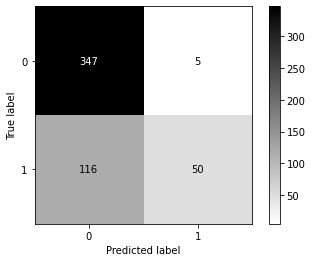

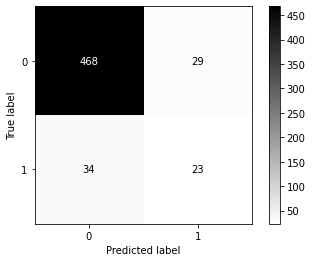

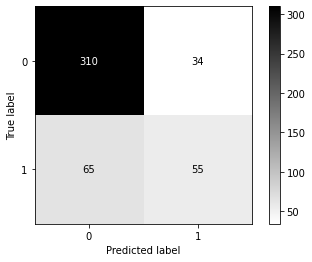

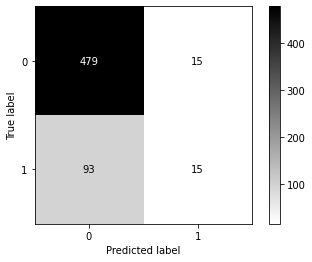

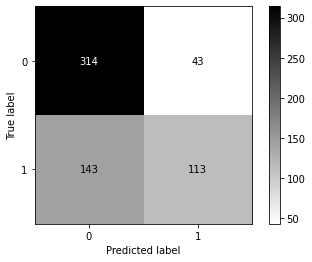

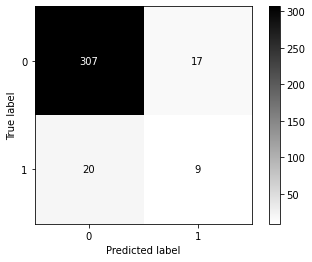

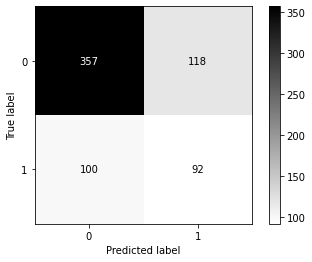

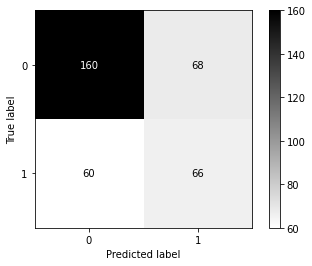

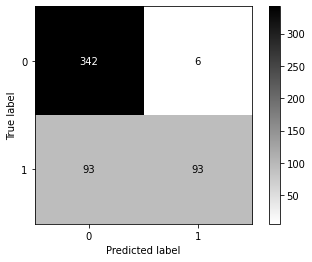

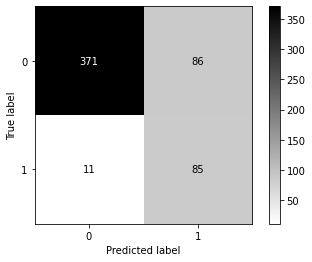

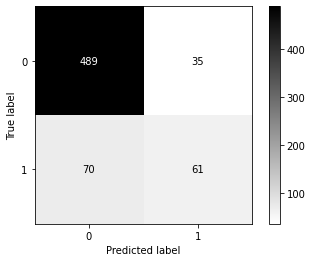

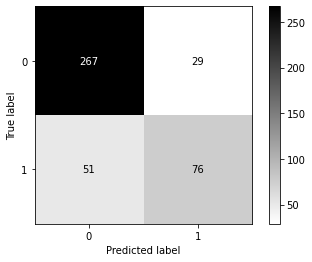

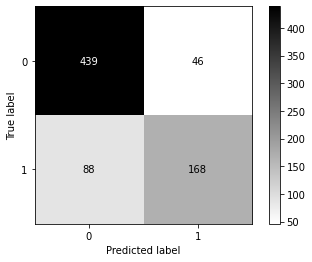

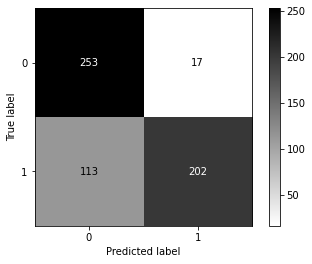

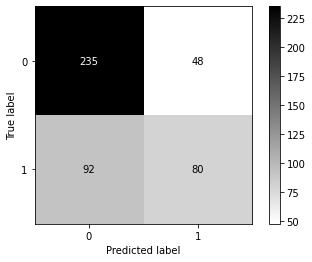

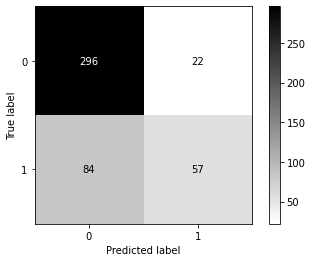

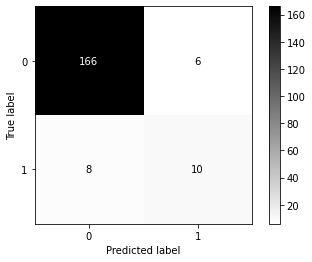

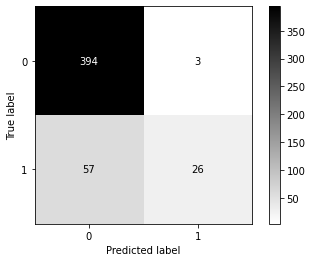

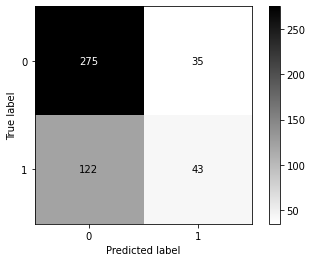

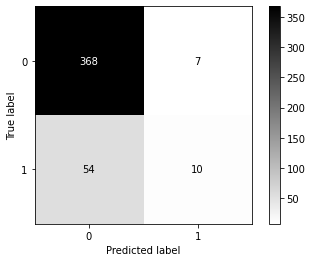

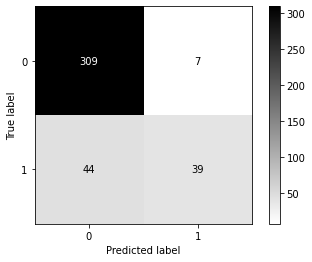

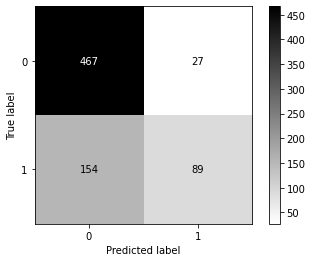

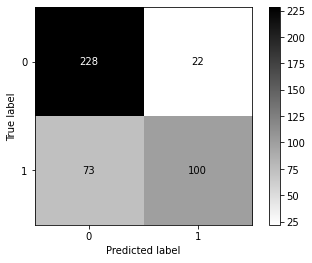

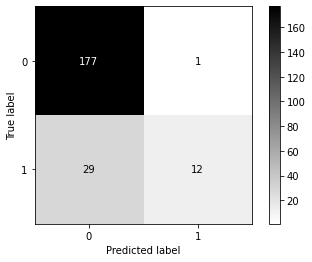

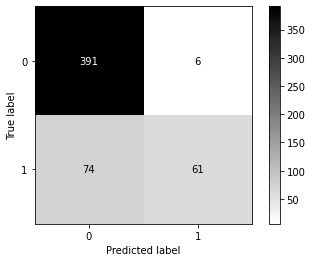

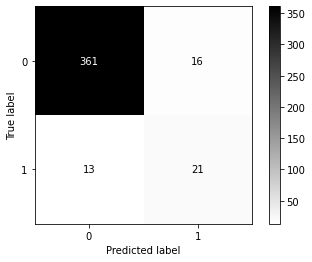

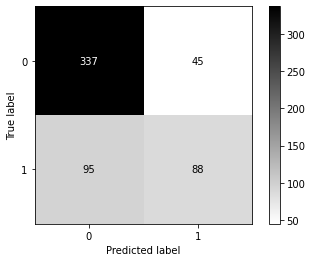

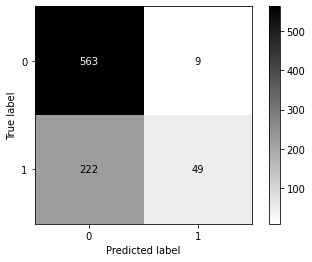

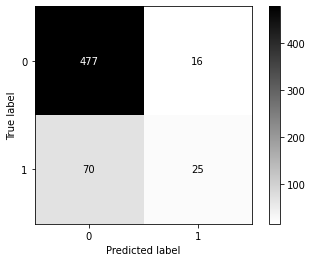

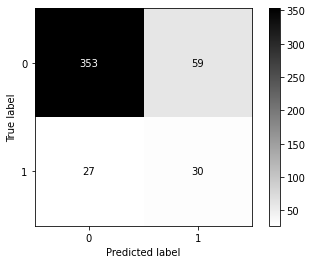

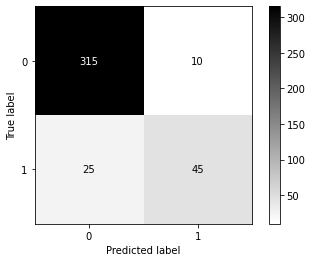

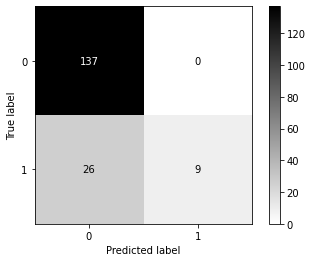

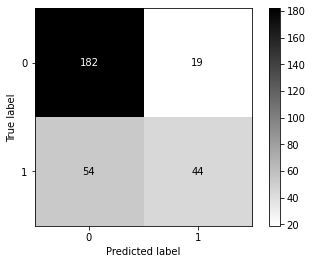

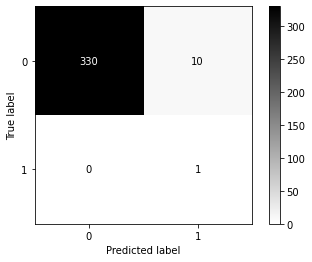

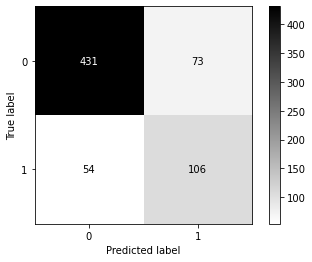

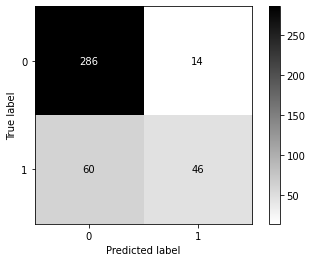

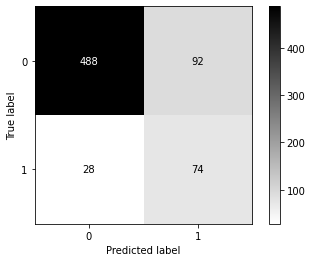

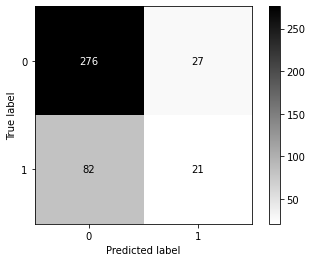

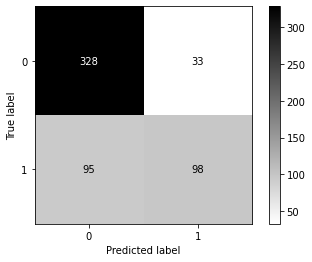

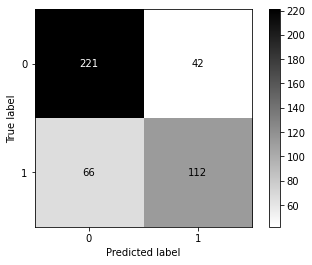

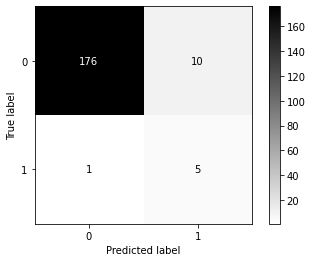

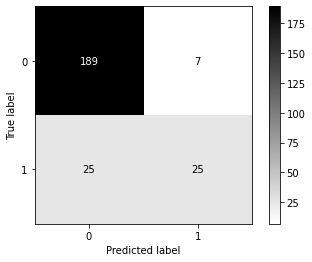

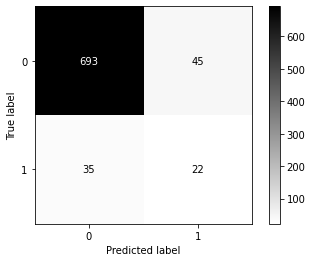

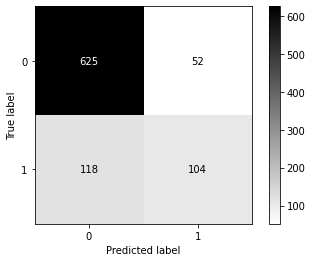

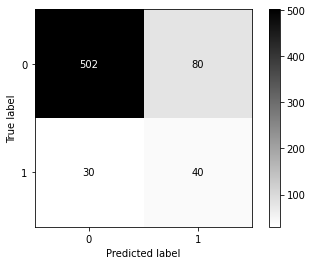

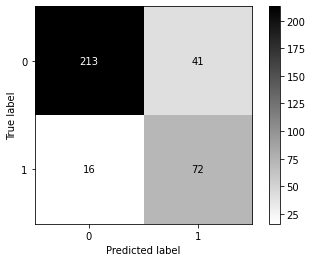

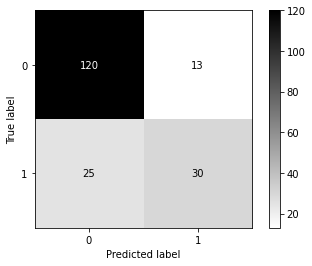

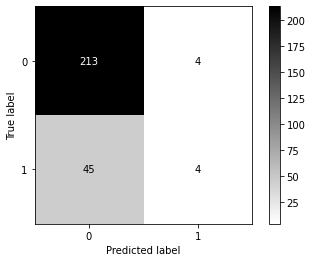

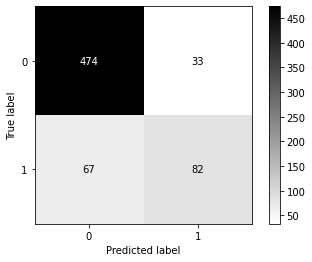

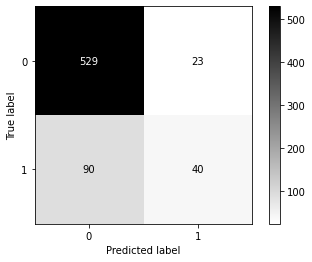

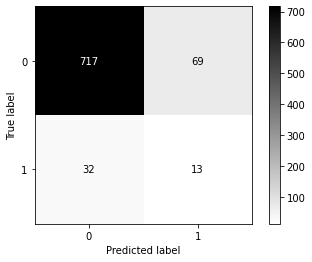

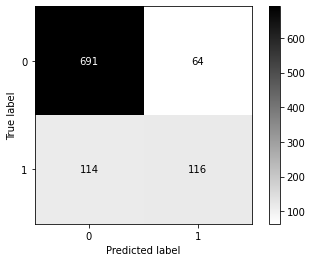

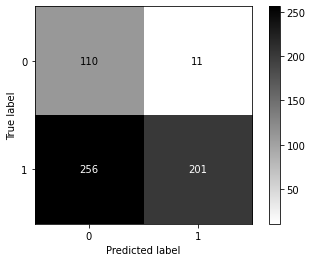

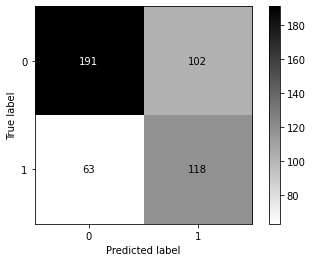

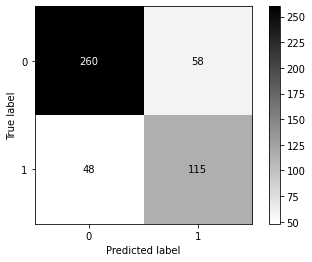

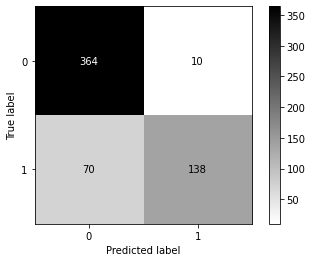

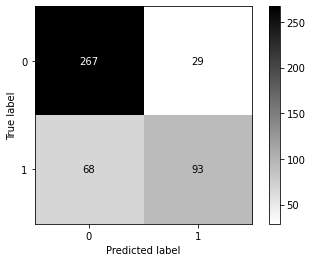

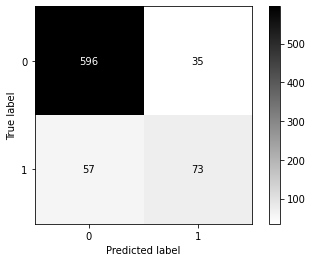

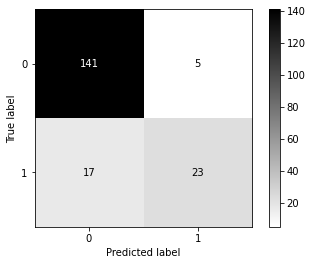

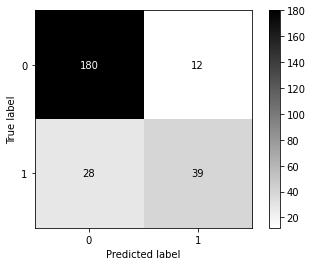

In [137]:
nm_doc_scores, nm_doc_dict, np_doc_par_score, np_doc_par_dict = model_utils.get_report_by_unit(fixed_near_miss,"ens","group",False)
all_doc_scores, all_doc_dict, all_doc_par_score, all_doc_par_dict = model_utils.get_report_by_unit(all_pred,"ens","group",False)
np.mean(nm_doc_scores),np.mean(all_doc_scores)

In [138]:
np.mean(nm_doc_scores),np.mean(all_doc_scores)

(0.7978730130722645, 0.796670339796042)

In [110]:
total_fn=len(all_pred[(all_pred['ens_true']==1) & (all_pred['ens_predicted']==0)])
total_fn

5280

In [111]:
total_fp=len(all_pred[(all_pred['ens_true']==0) & (all_pred['ens_predicted']==1)])
total_fp

2279

In [112]:
total_miss = len(all_pred[all_pred['ens_true']!=all_pred['ens_predicted']])
total_miss

7559

In [113]:
total_near_misses=0
near_fp=0
near_fn=0
for k,v in misses.items():
    for i,j in v.items():
        print("{:>8} {:>8}{:>4}".format(k,i,len(j)))
        total_near_misses+=len(j)
        if 'fp' in i:
            near_fp+=len(j)
            print('\t{:>4} ratio: {:.2f}'.format(i,len(j)*100/total_fp))
        if 'fn' in i:
            near_fn+=len(j)
            print('\t{:>4} ratio: {:.2f}'.format(i,len(j)*100/total_fn))

print('total {} fp {} fn {}'.format(total_near_misses,near_fp,near_fn))

   start     fp-1  32
	fp-1 ratio: 1.40
   start     fn+1  43
	fn+1 ratio: 0.81
     end     fn-1  56
	fn-1 ratio: 1.06
     end     fp+1  25
	fp+1 ratio: 1.10
total 156 fp 57 fn 99


In [150]:
near_miss_ratio=total_near_misses/total_miss
near_miss_ratio

0.020637650482868104

In [171]:
print(total_fp/total_miss,total_fn/total_miss)

0.30149490673369495 0.698505093266305


In [163]:
fp_miss_ratio=near_fp/total_fp
fp_miss_ratio

0.025010969723562967

In [165]:
fn_miss_ratio=near_fn/total_fn
fn_miss_ratio

0.01875

### Fix 1 sentence missing in the middle + near miss

In [145]:
true_narr=all_pred[all_pred['ens_true']==1]

In [155]:
middle_miss=true_narr['ens_predicted'].where(((true_narr['ens_predicted']==0) & (true_narr['ens_predicted'].shift(1) == 1) &(true_narr['ens_predicted'].shift(-1)==1)))
middle_miss.dropna(inplace=True)

In [159]:
mid_miss_indices=middle_miss.index.tolist()
len(mid_miss_indices)

281

In [160]:
fixed_near_mid_miss=fixed_near_miss.copy()

In [161]:
fixed_near_mid_miss.loc[mid_miss_indices,'ens_predicted']=1

### Ratio of near-miss among all false negative

In [167]:
len(mid_miss_indices)*100/total_fn

5.321969696969697

In [165]:
imp.reload(model_utils)
imp.reload(common_utils)
nm_mid_doc_scores, nm_mid_doc_dict, np_mid_doc_par_score, np_min_doc_par_dict = model_utils.get_report_by_unit(fixed_near_mid_miss,"ens","group",2,False)
np.mean(nm_mid_doc_scores)

/home/zsofya/jupyter_git/jup-nb-generic/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zsofya/jupyter_git/jup-nb-generic/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zsofya/jupyter_git/jup-nb-generic/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

0.8065861623384297

In [166]:
common_utils.save_db(fixed_near_mid_miss,dir_name,"svc.ens.fixed_near.mid_miss")

Saving /scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/reparse/svc.ens.fixed_near.mid_miss.csv,  index False


### Count stand-alone false positive

In [177]:
true_not_nar=all_pred[all_pred['ens_true']==0].copy()

In [178]:
true_not_nar

,bert_group,bert_split,bert_predicted,bert_true,bert_proba_0,bert_proba_1,bert_sent_idx,bert_par,crf_group,crf_par,...,crf_proba_0,crf_proba_1,crf_sent_idx,ens_par,ens_predicted,ens_group,ens_split,ens_true,ens_par_y,ens_sent_idx
0,4,0,0,0,0.735761,0.264239,0,0,4,0,...,0.928988,0.071012,0,0,0,4,0,0,0,0
1,4,0,0,0,0.809237,0.190763,1,1,4,1,...,0.948798,0.051202,1,1,0,4,0,0,1,1
2,4,0,0,0,0.830174,0.169826,2,2,4,2,...,0.963766,0.036234,2,2,0,4,0,0,2,2
3,4,0,0,0,0.627892,0.372108,3,3,4,3,...,0.891811,0.108189,3,3,0,4,0,0,3,3
4,4,0,0,0,0.656868,0.343132,4,3,4,3,...,0.769472,0.230528,4,3,0,4,0,0,3,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38776,79,9,0,0,0.795311,0.204689,254,171,79,171,...,0.972802,0.027198,254,171,0,79,9,0,171,254
38777,79,9,0,0,0.860838,0.139162,255,172,79,172,...,0.980269,0.019731,255,172,0,79,9,0,172,255
38778,79,9,0,0,0.875573,0.124427,256,172,79,172,...,0.989618,0.010382,256,172,0,79,9,0,172,256
38779,79,9,0,0,0.865315,0.134685,257,172,79,172,...,0.989894,0.010106,257,172,0,79,9,0,172,257


In [180]:
false_single_nar=true_not_nar['ens_predicted'].where(((true_not_nar['ens_predicted']==1) & 
                                                 (true_not_nar['ens_predicted'].shift(1) == 0) &
                                                 (true_not_nar['ens_predicted'].shift(-1)==0) &
                                                 (true_not_nar['ens_predicted'].shift(2)==0) &
                                                 (true_not_nar['ens_predicted'].shift(-2)==0)
                                                ))
false_single_nar.info()

<class 'pandas.core.series.Series'>
Int64Index: 28764 entries, 0 to 38780
Series name: ens_predicted
Non-Null Count  Dtype  
--------------  -----  
220 non-null    float64
dtypes: float64(1)
memory usage: 449.4 KB


In [182]:
false_single_nar.dropna(inplace=True)
false_single_nar

14       1.0
203      1.0
207      1.0
390      1.0
397      1.0
        ... 
38082    1.0
38403    1.0
38553    1.0
38602    1.0
38633    1.0
Name: ens_predicted, Length: 220, dtype: float64

In [188]:
stand_alone_indices=false_single_nar.index.tolist()
stand_alone_indices

[14,
 203,
 207,
 390,
 397,
 400,
 635,
 737,
 740,
 764,
 1198,
 1427,
 1431,
 1453,
 1828,
 1865,
 1964,
 2136,
 2327,
 2425,
 2561,
 2645,
 2878,
 2883,
 3083,
 3108,
 3368,
 3486,
 3660,
 3956,
 4094,
 4182,
 4185,
 5774,
 6009,
 6220,
 6292,
 6383,
 6435,
 6903,
 6954,
 6958,
 7093,
 7226,
 7327,
 7361,
 7427,
 7515,
 7593,
 7718,
 7907,
 8439,
 8966,
 9247,
 9263,
 9709,
 9726,
 9816,
 10219,
 10418,
 10472,
 10476,
 10872,
 10981,
 10984,
 11009,
 11199,
 11570,
 11829,
 11871,
 12161,
 12380,
 12604,
 12655,
 12810,
 13073,
 13343,
 13630,
 13649,
 13750,
 13753,
 13771,
 13776,
 13836,
 13839,
 13984,
 14535,
 14589,
 14674,
 14861,
 14899,
 14928,
 15198,
 15232,
 15662,
 16319,
 16426,
 16504,
 16530,
 16701,
 16791,
 17133,
 17154,
 17303,
 17628,
 18079,
 18509,
 18512,
 18744,
 19105,
 19214,
 19289,
 19320,
 19377,
 19442,
 20130,
 20312,
 20696,
 20826,
 21181,
 21533,
 21614,
 21726,
 21753,
 21757,
 22351,
 22957,
 23069,
 23238,
 23483,
 23904,
 23930,
 23983,
 2455

In [189]:
len(stand_alone_indices)*100/total_fp

9.653356735410268

In [190]:
fixed_near_mid_alone_miss=fixed_near_mid_miss.copy()

In [191]:
fixed_near_mid_alone_miss.loc[stand_alone_indices,'ens_predicted']=0

In [192]:
common_utils.save_db(fixed_near_mid_alone_miss,dir_name,"svc.ens.fixed_near.mid.alone_miss")

Saving /scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/reparse/svc.ens.fixed_near.mid.alone_miss.csv,  index False


In [193]:
imp.reload(model_utils)
imp.reload(common_utils)
nm_mid_alone_scores, nm_mid_alone_dict, np_mid_alone_par_score, np_min_alone_par_dict = model_utils.get_report_by_unit(fixed_near_mid_alone_miss,"ens","split",2,False)
np.mean(nm_mid_alone_scores)

0.8069612351373067

### Extract new narratives

In [177]:
all_pred[(all_pred['ens_true']==0) & (all_pred['ens_predicted']==1)]

,bert_group,bert_split,bert_predicted,bert_true,bert_proba_0,bert_proba_1,bert_sent_idx,bert_par,crf_group,crf_par,...,crf_proba_0,crf_proba_1,crf_sent_idx,ens_par_x,ens_predicted,ens_group,ens_split,ens_true,ens_par_y,ens_sent_idx
14,4,0,1,0,0.190261,0.809739,14,3,4,3,...,0.118391,0.881609,14,3,1,4,0,0,3,14
203,4,0,1,0,0.419259,0.580741,203,42,4,42,...,0.211463,0.788537,203,42,1,4,0,0,42,203
207,4,0,1,0,0.459416,0.540584,207,44,4,44,...,0.276978,0.723022,207,44,1,4,0,0,44,207
225,4,0,1,0,0.222399,0.777601,225,51,4,51,...,0.222949,0.777051,225,51,1,4,0,0,51,225
226,4,0,1,0,0.401245,0.598755,226,51,4,51,...,0.243167,0.756833,226,51,1,4,0,0,51,226
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38621,79,9,0,0,0.819654,0.180346,99,64,79,64,...,0.021746,0.978254,99,64,1,79,9,0,64,99
38625,79,9,1,0,0.324156,0.675844,103,68,79,68,...,0.199494,0.800506,103,68,1,79,9,0,68,103
38633,79,9,1,0,0.084766,0.915234,111,75,79,75,...,0.756211,0.243789,111,75,1,79,9,0,75,111
38646,79,9,1,0,0.121183,0.878817,124,83,79,83,...,0.545429,0.454571,124,83,1,79,9,0,83,124


In [254]:
all_pred=common_utils.load_db(dir_name,"bert.crf.svc.new.76")

Opened /scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/reparse/bert.crf.svc.new.76.csv,  index False


In [9]:
df=all_pred

In [10]:
non_nar=all_pred[all_pred['ens_true']==0]

In [14]:
false_nar=non_nar.query('ens_predicted==1')

In [62]:
false_nar_grouped=false_nar.groupby(false_nar.index - np.arange(len(false_nar)))['ens_group']

In [61]:
false_nar_grouped

In [22]:
len(false_nar_grouped)

770

In [32]:
new_nar={}
for i,(_, d) in enumerate(false_nar_grouped):
#     print(d.shape[0])
    new_nar[i]={}
    new_nar[i]['len']=d.shape[0]
    new_nar[i]['doc_idx']=d['ens_group'].unique()[0]
    new_nar[i]['sent_idx']=d['ens_sent_idx'].tolist()


#     if d.shape[0] > 1:
#         display(d)
    

In [33]:
new_nar

{0: {'len': 1, 'doc_idx': 4, 'sent_idx': [14]},
 1: {'len': 1, 'doc_idx': 4, 'sent_idx': [203]},
 2: {'len': 1, 'doc_idx': 4, 'sent_idx': [207]},
 3: {'len': 5, 'doc_idx': 4, 'sent_idx': [225, 226, 227, 228, 229]},
 4: {'len': 3, 'doc_idx': 4, 'sent_idx': [231, 232, 233]},
 5: {'len': 1, 'doc_idx': 4, 'sent_idx': [390]},
 6: {'len': 1, 'doc_idx': 4, 'sent_idx': [397]},
 7: {'len': 1, 'doc_idx': 4, 'sent_idx': [400]},
 8: {'len': 1, 'doc_idx': 14, 'sent_idx': [164]},
 9: {'len': 11,
  'doc_idx': 14,
  'sent_idx': [242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252]},
 10: {'len': 1, 'doc_idx': 14, 'sent_idx': [266]},
 11: {'len': 1, 'doc_idx': 14, 'sent_idx': [269]},
 12: {'len': 1, 'doc_idx': 14, 'sent_idx': [293]},
 13: {'len': 2, 'doc_idx': 15, 'sent_idx': [42, 43]},
 14: {'len': 1, 'doc_idx': 15, 'sent_idx': [59]},
 15: {'len': 1, 'doc_idx': 15, 'sent_idx': [144]},
 16: {'len': 1, 'doc_idx': 15, 'sent_idx': [146]},
 17: {'len': 1, 'doc_idx': 15, 'sent_idx': [288]},
 18: {'len': 1

In [37]:
imp.reload(common_utils)
common_utils.dump_to_file(new_nar,dir_name,'false.pos.narrative')

In [39]:
length={}
for i,v in new_nar.items():
    if len(v['sent_idx']) not in length:
        length[len(v['sent_idx'])]=1
    else:
        length[len(v['sent_idx'])]+=1
        

In [42]:
length

{1: 393,
 5: 26,
 3: 59,
 11: 7,
 2: 137,
 9: 10,
 15: 8,
 7: 17,
 4: 43,
 12: 8,
 6: 24,
 13: 6,
 8: 7,
 16: 4,
 21: 1,
 10: 11,
 14: 5,
 18: 1,
 24: 2,
 22: 1}

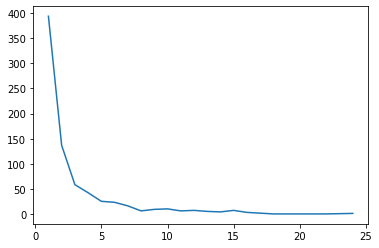

In [45]:
lists = sorted(length.items()) # sorted by key, return a list of tuples

x, y = zip(*lists) # unpack a list of pairs into two tuples

plt.plot(x, y)
plt.show()

In [47]:
total_new_narr=sum(length.values())

In [65]:
for k,v in sorted(length.items()):
    print("{} {:>.2f}".format(k,v*100/total_new_narr))

1 51.04
2 17.79
3 7.66
4 5.58
5 3.38
6 3.12
7 2.21
8 0.91
9 1.30
10 1.43
11 0.91
12 1.04
13 0.78
14 0.65
15 1.04
16 0.52
18 0.13
21 0.13
22 0.13
24 0.26


In [204]:
all_pred['crf_predicted']

0        not_nar
1        not_nar
2        not_nar
3        not_nar
4        not_nar
          ...   
38776    not_nar
38777    not_nar
38778    not_nar
38779    not_nar
38780    not_nar
Name: crf_predicted, Length: 38781, dtype: object

In [255]:
all_pred_crf01 = all_pred.replace({'crf_predicted': 'is_nar', 'crf_true': 'is_nar'}, 
    {'crf_predicted': 1, 'crf_true': 1}, regex=True)
all_pred_crf01 = all_pred_crf01.replace({'crf_predicted': 'not_nar', 'crf_true': 'not_nar'}, 
    {'crf_predicted': 0, 'crf_true': 0}, regex=True)
all_pred_crf01['crf_predicted'].unique()

array([0, 1])

In [256]:
common_utils.save_db(all_pred_crf01,dir_name,"bert.crf.svc.new.76.label.01")

Saving /scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/reparse/bert.crf.svc.new.76.label.01.csv,  index False


In [259]:
imp.reload(classes)
pred_fixer=classes.MyPredFixer(all_pred_crf01)

MyPredFixer init called
WindowDiff init called


In [260]:
pred_fixer.fix_error_all_prefix()

bert
2 near misses to be fixed
1039 middle misses to be fixed
1428 stande alone to be fixed
crf
2 near misses to be fixed
23 middle misses to be fixed
24 stande alone to be fixed
ens
2 near misses to be fixed
281 middle misses to be fixed
220 stande alone to be fixed


In [264]:
imp.reload(classes)
imp.reload(model_utils)
my_tables=classes.MyScoreSummarizer(all_pred_crf01)
my_tables.get_all_scores()

MyScoreSummarizer init called
MyPredFixer init called
WindowDiff init called
bert
near misses to be fixed
 {'tot': 346, 'fp': 162, 'fn': 184}
1039 middle misses to be fixed
1428 stande alone to be fixed
crf
near misses to be fixed
 {'tot': 100, 'fp': 48, 'fn': 52}
23 middle misses to be fixed
24 stande alone to be fixed
ens
near misses to be fixed
 {'tot': 156, 'fp': 57, 'fn': 99}
281 middle misses to be fixed
220 stande alone to be fixed
MyReport init called
MyReport init called
MyReport init called


In [265]:
for k,v in my_tables.print_df.items():
    print(k)
    display(v)

bert


,sent_f1,fixed_f1,par_f1,sent_recall,fixed_recall,par_recall,sent_prec,fixed_prec,par_prec
0,0.820226,0.863883,0.814289,0.809126,0.856247,0.755762,0.835163,0.874794,0.886847
1,0.515761,0.625466,0.467037,0.545716,0.652194,0.612560,0.503458,0.616833,0.387257
weighted avg,0.744586,0.804972,0.747545,0.740042,0.802285,0.726106,0.756066,0.814337,0.792190


crf


,sent_f1,fixed_f1,par_f1,sent_recall,fixed_recall,par_recall,sent_prec,fixed_prec,par_prec
0,0.859127,0.859808,0.886444,0.884974,0.885212,0.903634,0.835504,0.836585,0.870513
1,0.544544,0.547704,0.493692,0.499708,0.503458,0.459468,0.606244,0.608521,0.541543
weighted avg,0.781183,0.782492,0.810291,0.788503,0.789642,0.816288,0.779935,0.781313,0.808117


ens


,sent_f1,fixed_f1,par_f1,sent_recall,fixed_recall,par_recall,sent_prec,fixed_prec,par_prec
0,0.873889,0.881856,0.898939,0.921331,0.927594,0.927538,0.832262,0.841555,0.872946
1,0.549619,0.582796,0.518216,0.469672,0.501881,0.458067,0.677116,0.709716,0.606784
weighted avg,0.792773,0.806961,0.824917,0.805330,0.818131,0.833950,0.797360,0.812198,0.824349


In [266]:
for k,v in my_tables.latex_str.items():
    print(k)
    display(v)

bert


'&sent_f1&fixed_f1&par_f1&sent_recall&fixed_recall&par_recall&sent_prec&fixed_prec&par_prec\\0&0.820&0.864&0.814&0.809&0.856&0.756&0.835&0.875&0.887\\1&0.516&0.625&0.467&0.546&0.652&0.613&0.503&0.617&0.387\\weighted avg&0.745&0.805&0.748&0.740&0.802&0.726&0.756&0.814&0.792\\'

crf


'&sent_f1&fixed_f1&par_f1&sent_recall&fixed_recall&par_recall&sent_prec&fixed_prec&par_prec\\0&0.859&0.860&0.886&0.885&0.885&0.904&0.836&0.837&0.871\\1&0.545&0.548&0.494&0.500&0.503&0.459&0.606&0.609&0.542\\weighted avg&0.781&0.782&0.810&0.789&0.790&0.816&0.780&0.781&0.808\\'

ens


'&sent_f1&fixed_f1&par_f1&sent_recall&fixed_recall&par_recall&sent_prec&fixed_prec&par_prec\\0&0.874&0.882&0.899&0.921&0.928&0.928&0.832&0.842&0.873\\1&0.550&0.583&0.518&0.470&0.502&0.458&0.677&0.710&0.607\\weighted avg&0.793&0.807&0.825&0.805&0.818&0.834&0.797&0.812&0.824\\'